## CNN-RNN Forward Proxy Modeling for CO2 Monitoring

***

In [4]:
from utils2d import *

mydir = 'C:/Users/381792/Documents/MLTrainingImages'
facies = np.zeros((318,128,128,3))
for root, dirs, files in os.walk(mydir):
    for file in files:
        if file.endswith('.mat'):
            name = os.path.join(root,file)
            facies[i] = resize(loadmat(name)['Facies'].reshape(128,256,256).T, (128,128,3), preserve_range=True, anti_aliasing=True)

In [11]:
permdf = np.array(pd.read_csv('simulations2D/perm2d.csv')).reshape(128,128,1000).T

In [116]:
import glob, os
import pyvista as pv
from scipy.io import savemat
from skimage.transform import resize, rescale, downscale_local_mean
from sklearn.preprocessing import MinMaxScaler

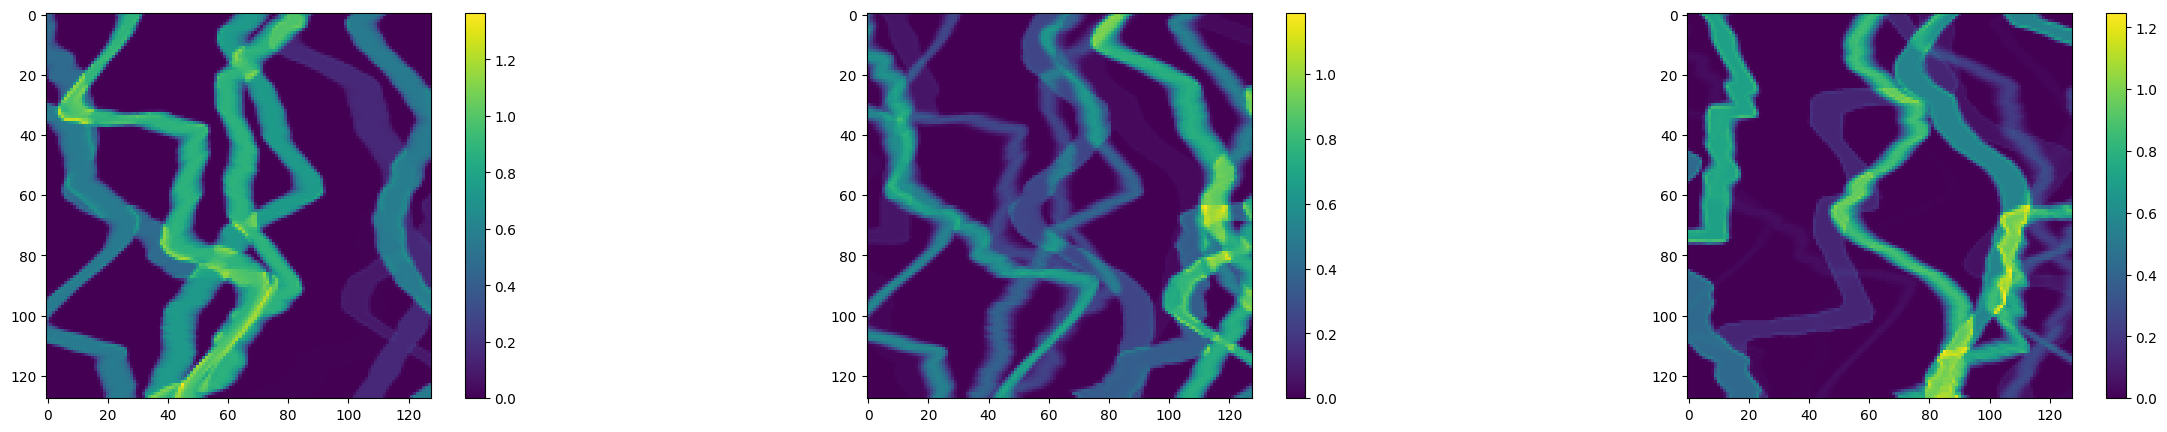

In [173]:
dat = loadmat('C:/Users/381792/Documents/MLTrainingImages/Fluvsim/Channel/NTG_0.2/ThickWT_50Med_Sinuosity.mat')['Facies']
facies = resize(dat.reshape(128,256,256).T, (128,128,3), preserve_range=True, anti_aliasing=True)

plt.figure(figsize=(30,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(facies[...,i]); plt.colorbar()
plt.show()

In [200]:
mydir = 'C:/Users/381792/Documents/MLTrainingImages'

facies = np.zeros((318,128,128,4))

for root, dirs, files in os.walk(mydir):
    for file in files:
        if file.endswith('.mat'):
            name = os.path.join(root,file)
            facies[i] = resize(loadmat(name)['Facies'].reshape(128,256,256).T, (128,128,4), preserve_range=True, anti_aliasing=True)

In [198]:
facies_1 = facies[:,:,:,0]
facies_2 = facies[:,:,:,1]
facies_3 = facies[:,:,:,2]
facies_4 = facies[:,:,:,3]

facies_data = np.concatenate([facies_1, facies_2, facies_2, facies_4], axis=0)
print(facies_data.shape)

(954, 128, 128)


In [199]:
318*3

954

In [2]:
check_tensorflow_gpu()

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.10.0
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
poro, perm, saturation, pressure = load_process_data()

poro_aug, perm_aug, saturation_aug, pressure_aug = augment_data(poro, perm, saturation, pressure)

plot_dataset(poro_aug, perm_aug, saturation_aug, nrows=6, row_mult=100, figsize=(16,10))

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/saturation.mat'

We normalize the data to be $\in[0,1]$; this is known as Min-Max Normalization. This improves the prediction performance of the proxy model given the properties of the activation functions and optimizers in the deep learning framework.

In [ ]:
# Min-Max Normalize predicted saturation values ~ [0,1]
perm_min = perm_aug.min(axis=(1,2), keepdims=True)
perm_max = perm_aug.max(axis=(1,2), keepdims=True)
perm_processed = (perm_aug - perm_min)/(perm_max-perm_min)

sat_min = saturation_aug.min(axis=(1,2), keepdims=True)
sat_max = saturation_aug.max(axis=(1,2), keepdims=True)
sat_processed = (saturation_aug - sat_min)/(sat_max-sat_min)

print('Processed Permeability shape: {}'.format(perm_processed.shape))
print('Processed Saturation shape:   {}'.format(sat_processed.shape))

We perform train/test split by randomly generating a set of indices that will be assigned to the training set and the remainder to the testing set. 

In [ ]:
# Randomly generate train-test indices
split_perc = (2/3)
train_size = int(np.ceil(N_real*2 * split_perc))
test_size  = int(np.floor(N_real*2 * (1-split_perc)))

train_idx = np.random.choice(N_real*2, size=train_size, replace=False)
test_idx  = np.setdiff1d(np.arange(N_real*2), train_idx)

# Train/Test split
X_train = np.expand_dims(perm_processed[train_idx,:,:], axis=-1)
X_test  = np.expand_dims(perm_processed[test_idx,:,:],  axis=-1)
y_train = np.expand_dims(sat_processed[train_idx,:,:,:], axis=-1)
y_test  = np.expand_dims(sat_processed[test_idx,:,:,:],  axis=-1)

print('X_train shape: {} | y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_test  shape: {} | y_test  shape: {}'.format(X_test.shape,  y_test.shape))

We visualize the distribution of mean permeability and mean end-state saturation for the training and testing datasets. This is a measure to ensure that the training set is representative of the testing, and that no induced bias will be introduced in training so that the model can generalize well to the testing set.

In [ ]:
# Visualize Train/Test distributions (mean, flattened)
X_train_f = X_train.reshape(train_size, dim*dim)
X_test_f  = X_test.reshape(test_size, dim*dim)

y_train_f = y_train[:,:,:,-1].reshape(train_size, dim*dim)
y_test_f  = y_test[:,:,:,-1].reshape(test_size, dim*dim)

plot_histograms(X_train_f, X_test_f, y_train_f, y_test_f)

***

### 5. CNN-RNN Forward Proxy

The model is a hybrid CNN-RNN architecture that will learn how to forecast dynamic states from the latent representation of the static reservoir properties (a reduced-order forward model). The architecture is designed as follows:

1. Convolution block: dimensionality reduction from high-resolution permeability to a latent space
2. Recurrent block: dynamic predictions in latent space
3. Deconvolution block: reconstruct high-resolution saturation maps as a time-series


In [ ]:
# (re)-Set Keras environment
keras.backend.clear_session()
tf.keras.backend.set_floatx('float32')

In [ ]:
# Define proxy model by blocks
global_reg = 1e-4

# Convolutional block (Encoder)
def conv_block(filt, inp, kern=(3,3), reg=global_reg):
    x = Conv2D(filters=filt, kernel_size=kern, padding='same', activation=LeakyReLU(alpha=0.3))(inp)
    x = Conv2D(filters=filt, kernel_size=kern, padding='same', kernel_regularizer=regularizers.l2(reg))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x

# Recurrent block
def rnn_block(units, inp, drop=0.2):
    x = Flatten()(inp)
    x = RepeatVector(n=125)(x)
    x = GRU(units=units, return_sequences=True, dropout=drop)(x)
    x = Reshape((5,5,5, x.shape[-1]))(x)
    return x

# Transpose Convolutional block (Decoder)
def convT_block(filt, stride, inp, kern=(3,3,3), reg=global_reg):
    x = Conv3DTranspose(filters=filt, kernel_size=kern, padding='same', strides=1,      activation=LeakyReLU(alpha=0.3))(inp)
    x = Conv3DTranspose(filters=filt, kernel_size=kern, padding='same', strides=stride, activation=LeakyReLU(alpha=0.3))(x)
    x = Conv3DTranspose(filters=filt, kernel_size=kern, padding='same', kernel_regularizer=regularizers.l2(reg))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    return x

# Output block
def output_block(filt, inp, kern=(3,3,3)):
    x = Conv3DTranspose(filters=filt[0], kernel_size=kern, padding='same', activation='sigmoid')(inp)
    x = Conv3D(filters=filt[1], kernel_size=kern, padding='same', activation='sigmoid')(x)
    return x


In [ ]:
# Define CNN-RNN forward proxy model
def make_proxy():
    keras.backend.clear_session()

    # Input layer
    inp = Input(shape=(dim,dim,1))

    # Encoder block
    x = conv_block(filt=8,  inp=inp)
    x = conv_block(filt=16, inp=x)
    x = conv_block(filt=32, inp=x)
    x = conv_block(filt=64, inp=x)

    # Recurrent block
    x = rnn_block(units=128, inp=x)

    # Decoder block
    x = convT_block(filt=64, stride=2, inp=x)
    x = convT_block(filt=32, stride=2, inp=x)
    x = convT_block(filt=16, stride=3, inp=x)

    # Output block
    out = output_block(filt=[8,1], inp=x)

    proxy_model = Model(inp, out)
    return proxy_model

In [ ]:
model = make_proxy()
print('Number of parameters: {:,}'.format(model.count_params()))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile model
opt = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(optimizer = opt,
                loss    = 'mse',
                metrics = ['mse'])

# Fit the model
start = time()
fit = model.fit(X_train, y_train,
                    shuffle          = True,
                    epochs           = 300,
                    validation_split = 0.25,
                    batch_size       = 40,
                    workers          = 10,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))

# Visualize training process
plot_loss(fit)

In [ ]:
########################################
##### Save/Load (pre)trained model #####
########################################

model.save('model.h5')
#model = keras.models.load_model('model.h5')

Next we visualize the training performance. This includes computing MSE and SSIM metrics for the true training data and model-predicted training data. We also plot in a single image the permeability map (features) and the true and predicted saturation states (targets).

In [ ]:
# Predict TRAIN dynamic saturation states
y_train_hat = model.predict(X_train).squeeze().astype('float64')

# MinMax Normalize predicted saturation values ~ [0,1]
y_min  = y_train_hat.min(axis=(1,2), keepdims=True)
y_max  = y_train_hat.max(axis=(1,2), keepdims=True)
y_train_pred = ((y_train_hat - y_min)/(y_max-y_min))

# Squeeze the training dataset
y_train = y_train.squeeze()

# Print shapes
print('y_train_pred shape: {}'.format(y_train_pred.shape))
print('y_train shape:      {}'.format(y_train.shape))

In [ ]:
# Compute error metrics for training data
mse_train  = mean_squared_error(y_train, y_train_pred)
ssim_train = structural_similarity(y_train, y_train_pred)
print('MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))

We also visualize the testing performance. We compute the MSE and SSIM metrics for the true testing data and model-predicted testing data. Lastly, we plot in a single image the permeability maps (features) and the true and predicted saturation states (targets).

In [ ]:
# Compare true vs. training saturations for a set of permeability realizations
compare_results_plot(X_train, y_train, y_train_pred, nrows=4, row_mult=25)

In [ ]:
# Predict TEST dynamic saturation states
y_test_hat = model.predict(X_test).squeeze().astype('float64')

# MinMax Normalize predicted saturation values ~ [0,1]
y_min  = y_test_hat.min(axis=(1,2), keepdims=True)
y_max  = y_test_hat.max(axis=(1,2), keepdims=True)
y_test_pred = ((y_test_hat - y_min)/(y_max-y_min))

# Squeeze the testing data
y_test = y_test.squeeze()

# Print shapes
print('y_test_pred shape: {}'.format(y_test_pred.shape))
print('y_test shape:      {}'.format(y_test.shape))

In [ ]:
# Compute error metrics for testing data
mse  = mean_squared_error(y_test, y_test_pred)
ssim = structural_similarity(y_test, y_test_pred)
print('MSE: {:.3f} | MSSIM: {:.3f}'.format(mse, ssim))

In [ ]:
# Compare true vs. testing predicted saturations for a set of permeability realizations
compare_results_plot(X_test, y_test, y_test_pred, nrows=4, row_mult=25)

***
# END